In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

if 'path' in locals(): os.chdir(path)
else: os.chdir("../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/"
from pyMFI import MFI
from pyMFI import MFI1D
from pyMFI import run_plumed

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 22})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False

# load ref surface 40M
os.chdir(path_manustript + "Figure1B")
FES_ref = MFI.load_pkl("AD_ref_fes")

The path is: /home/ucecabj/Desktop/MFI_git


### Analyse Alanine Dipeptide simulation with MFI

In [9]:
###--- Analyse the data with MFI
#Read the HILLS and Colvar data
os.chdir(path_manustript + "Figure1B")
HILLS=MFI.load_HILLS_2D(hills_name="HILLS40")
[position_x, position_y] = MFI.load_position_2D(position_name="position40")

#Compute the time-independent mean force and free energy surface
NH=10000
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.1,0.1], kT = 2.49, error_pace=int(NH/500), WellTempered=1, nhills=NH, periodic = [1,1], ref_fes=FES_ref, use_weighted_st_dev=False)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results

# #integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=[-np.pi, -np.pi], max_grid=[np.pi, np.pi], periodic=[1,1])

#Find Absolute deviation
AD = abs(FES_ref - FES) 
ADc = AD * cutoff
AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
AADc = np.sum(ADc)/(np.count_nonzero(ADc))
print("\nAAD =" ,round(AAD,2) , "   |    AAD_cut =", round(AADc,2))

# rename results for later use
[FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1, aad_history_1, volume_history_1] = [FES, Ftot_den, ofe, ADc, cutoff, time_history, ofe_history, aad_history, volume_history]


|**************************************************| 100% | Average Mean Force Error: 4.963
AAD = 2.32    |    AAD_cut = 0.79


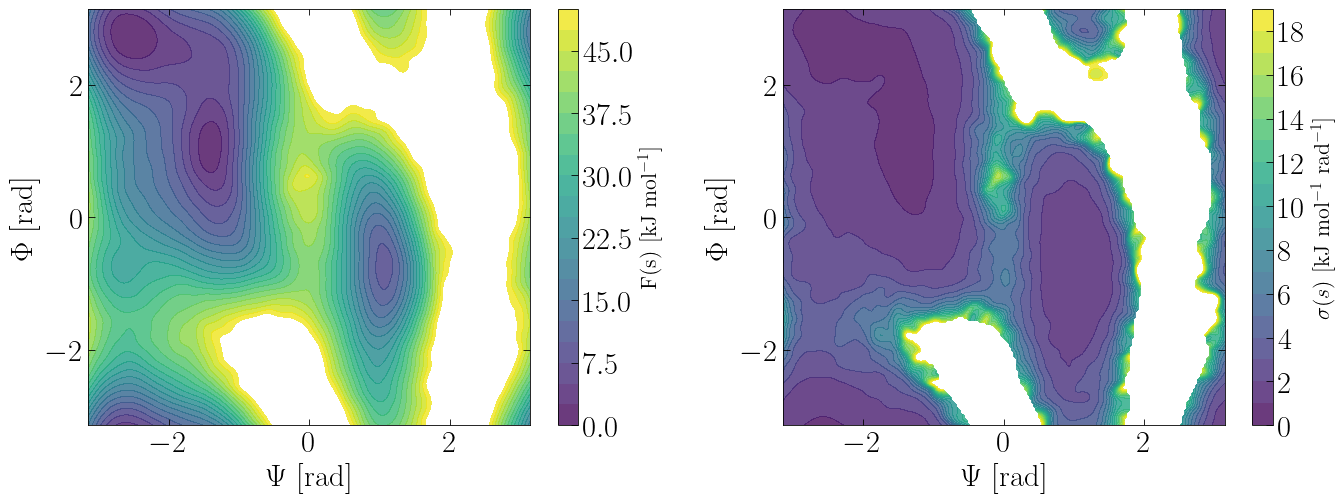

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5.5))
cp = axs[0].contourf(X, Y, FES_1, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_ylabel('$\Phi$ [rad]')
axs[0].set_xlabel('$\Psi$ [rad]')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


ofe_1[cutoff_1==0]=np.NaN

cp = axs[1].contourf(X, Y, ofe_1, levels=np.arange(0, 20, 1), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=16)
axs[1].set_ylabel('$\Phi$ [rad]')
axs[1].set_xlabel('$\Psi$ [rad]')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()    

# plt.savefig('Figure1B_1', dpi=600, bbox_inches='tight')

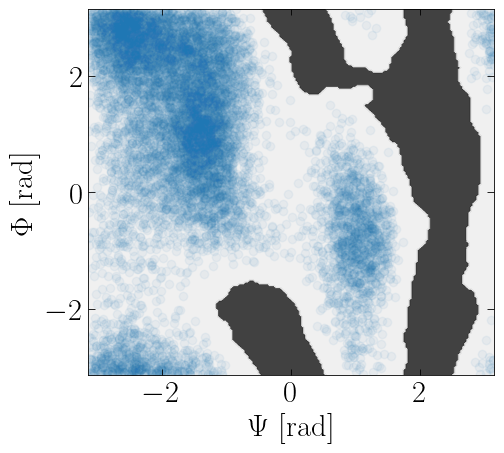

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(5.5, 5))

cp = axs.contourf(X, Y, cutoff, cmap='gray', antialiased=False, alpha=0.8);
#cbar = plt.colorbar(cp, ax=axs)
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

cp=axs.scatter(HILLS[0:NH,1],HILLS[0:NH,2],alpha=0.05);
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()
# plt.savefig('Figure1B_3', dpi=600, bbox_inches='tight')

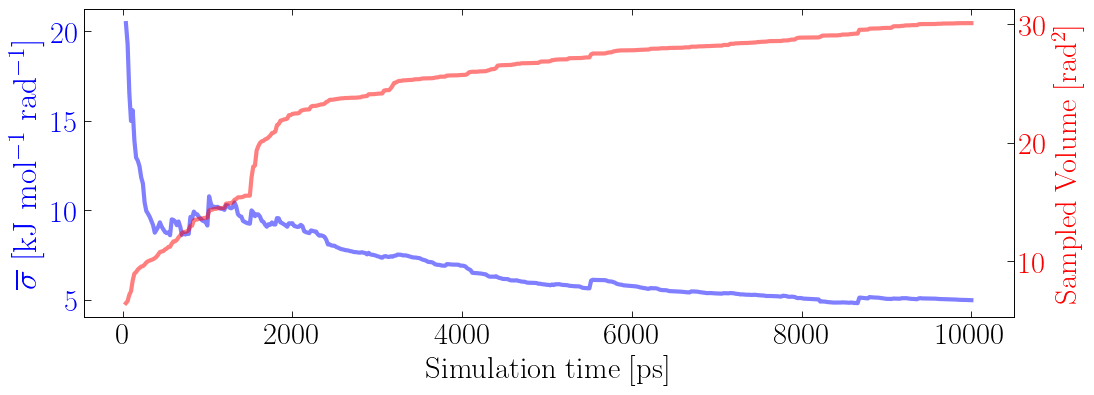

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot( [time for time in time_history[1:]], (ofe_history[1:NH]),color='blue',alpha=0.5,linewidth=3);
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$ rad$^{-1}$]',fontsize=24, color='blue')
axs.tick_params(axis ='y', labelcolor = 'blue')
axs.set_xlabel('Simulation time [ps]')

V=np.multiply(volume_history[1:NH],np.power(2*np.pi,2))
ax2 = axs.twinx()
ax2.set_xlabel('Simulation steps')
ax2.set_ylabel('Sampled Volume [rad$^2$]',color='red')
ax2.tick_params(axis ='y', labelcolor = 'red')
ax2.plot( [time for time in time_history[1:]], np.multiply(volume_history[1:NH],np.power(2*np.pi,2)),color='red',alpha=0.5,linewidth=3);

# plt.savefig('Figure1B_2', dpi=600, bbox_inches='tight')

### Plot results after 500 Hills

|**************************************************| 100% | Average Mean Force Error: 8.776

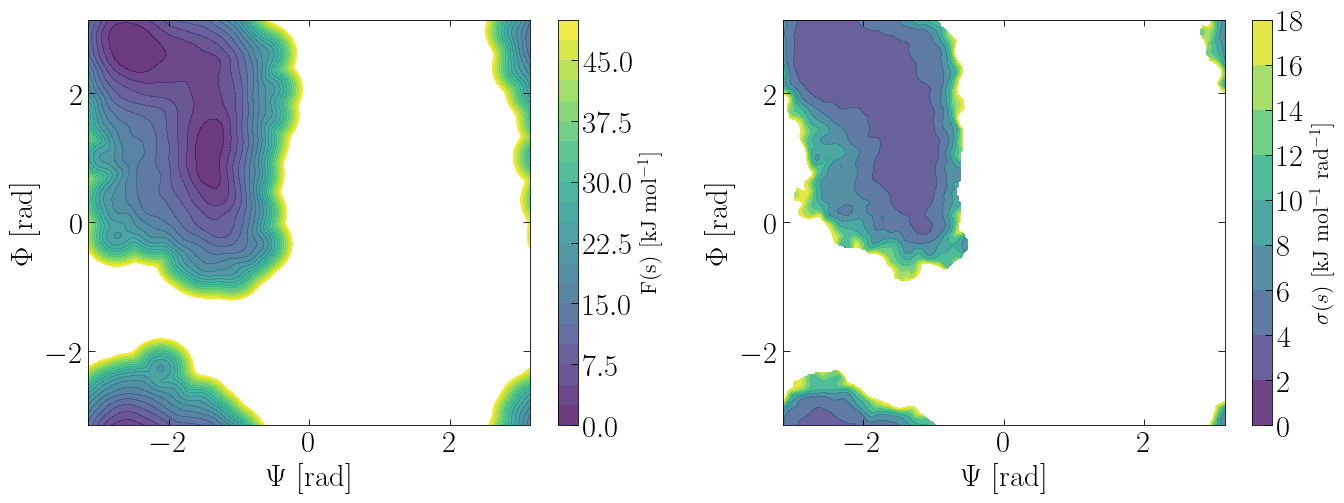

In [14]:
NH=500

#Compute the time-independent mean force
results2 = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.1,0.1], kT = 2.49, error_pace = 10, nhills=NH, periodic = [1,1],use_weighted_st_dev=False)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results2

# #integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), periodic = np.array((1,1)))

fig, axs = plt.subplots(1, 2, figsize=(14, 5.5))
cp = axs[0].contourf(X, Y, FES, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0]); cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16); axs[0].set_ylabel('$\Phi$ [rad]'); axs[0].set_xlabel('$\Psi$ [rad]'); axs[0].set_xlim(np.min(X),np.max(X)); axs[0].set_ylim(np.min(Y),np.max(Y))

ofe[cutoff==0]=np.NaN
cp = axs[1].contourf(X, Y, ofe, levels=np.arange(0, 20, 2), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1]); cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=16); axs[1].set_ylabel('$\Phi$ [rad]'); axs[1].set_xlabel('$\Psi$ [rad]'); axs[1].set_xlim(np.min(X),np.max(X)); axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout(); plt.show()

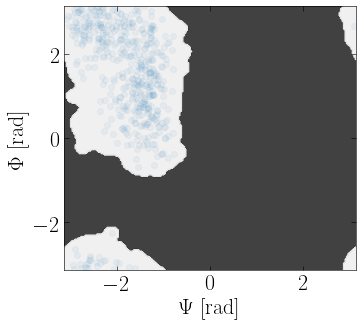

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(5.5, 5))

cp = axs.contourf(X, Y, cutoff, cmap='gray', antialiased=False, alpha=0.8);
#cbar = plt.colorbar(cp, ax=axs)
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

cp=axs.scatter(HILLS[0:NH,1],HILLS[0:NH,2],alpha=0.05);
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()


# plt.savefig('Figure1B_4', dpi=600, bbox_inches='tight')

(200, 200)
|**************************************************| 100% | Average Mean Force Error: 9.275

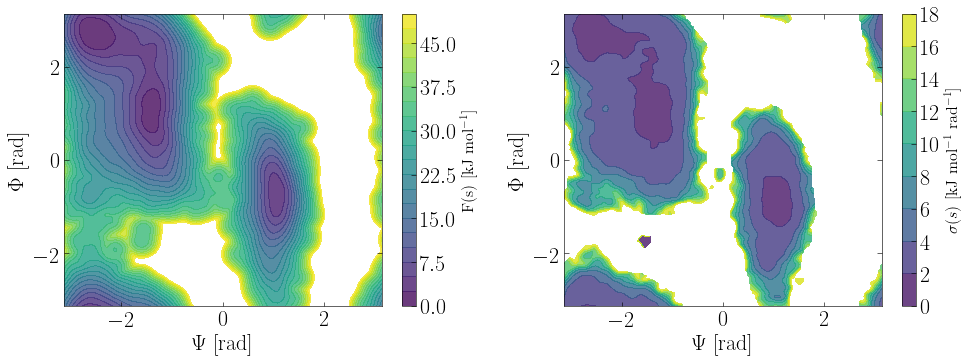

In [13]:
NH=2000

##Compute the time-independent mean force
results3 = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = np.array((0.1,0.1)), kT = 2.49, error_pace = 100, WellTempered=1, nhills=NH, periodic = np.array((1,1)),use_weighted_st_dev=False)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y, aadMAP, ofeMAP] = results3


##integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), periodic = np.array((1,1)))

fig, axs = plt.subplots(1, 2, figsize=(14, 5.5))
cp = axs[0].contourf(X, Y, FES, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_ylabel('$\Phi$ [rad]')
axs[0].set_xlabel('$\Psi$ [rad]')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))

ofe[cutoff==0]=np.NaN
cp = axs[1].contourf(X, Y, ofe, levels=np.arange(0, 20, 2), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=16)
axs[1].set_ylabel('$\Phi$ [rad]')
axs[1].set_xlabel('$\Psi$ [rad]')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()  

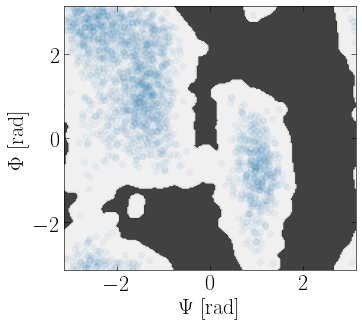

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(5.5, 5))

cp = axs.contourf(X, Y, cutoff, cmap='gray', antialiased=False, alpha=0.8);
#cbar = plt.colorbar(cp, ax=axs)
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

cp=axs.scatter(HILLS[0:NH,1],HILLS[0:NH,2],alpha=0.05);
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()


# plt.savefig('Figure1B_5', dpi=600, bbox_inches='tight')